# Multi-label Disease Classification from Medline Articles

A huge number of journal articles are published each year focusing on various kinds of diseases. The number of articles is further increased due to the overlapping of scope of various subjects; for instance, articles on medicine and journals on chemistry may both focus on autoimmune diseases.

We'll use this notebook to develop a model which will take in MEDLINE articles and will classify it into one or more disease categories (or even none of the categories) based on the abstract of the article.

#### Import basic packages & set seed for reproducibility

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import datetime
import matplotlib.pyplot as plt

np.random.seed(7)

#### Load packages specific to MEDLINE
Use "Medline" package from "biopython" to parse the MEDLINE file(s)

_Details of the package are found in:_
* _http://biopython.org/_
* _http://biopython.org/DIST/docs/api/Bio-module.html_
* _http://biopython.org/DIST/docs/api/Bio.Medline-module.html_

In [2]:
from collections import defaultdict
from Bio import Medline

## Vectorization of Words (Word Embedding)
Natural language processing (NLP) systems traditionally treat words as discrete atomic symbols. For example, ‘tiger’ may be represented as “W1” and 'cat' as “W2”. These encodings are arbitrary and provide no useful information regarding the relationships that may exist between the individual symbols. Representing words as unique, discrete symbols furthermore leads to data sparsity, and usually means that we may need more data in order to successfully train statistical models. Using vector representations can overcome some of these obstacles.

We want these vectors to be created in such a way that they somehow represent the word and its context, meaning, and semantics. For example, we’d like the vectors for the words ‘tiger’ and ‘cat’ to reside in relatively the same area in the vector space when compared to ‘car’ since they’re both animals of the same family of species (viz., ‘Felidae’). The vector representation of a word is also known as a word embedding.

To create these “word embedding” (i.e. vector representation of words), we will use the famous “Word2Vec” model instead of reinventing the wheel. The Word2Vec model is created by Google – one of the biggest players in the ML game and was trained on a massive Google News dataset that contained over 100 billion different words.

In [3]:
import gensim

# Load pre-trained Word2Vec model
modelWord2Vec = gensim.models.KeyedVectors.load_word2vec_format('../utils/PubMed-and-PMC-w2v.bin', binary=True)
vocab_size = len(modelWord2Vec.wv.vocab)

print('Loaded the word vectors!')
print('Total number of words:', vocab_size)
print('Most common words:', modelWord2Vec.wv.index2word[0], modelWord2Vec.wv.index2word[1], modelWord2Vec.wv.index2word[2])
print('Least common words:', modelWord2Vec.wv.index2word[vocab_size-1], modelWord2Vec.wv.index2word[vocab_size-2], modelWord2Vec.wv.index2word[vocab_size-3])

Loaded the word vectors!
Total number of words: 4087446
Most common words: </s> the ,
Least common words: Fl-NC(11-55) MAA-mediated balsalazide-treated


/home/sxd24/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/home/sxd24/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/home/sxd24/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


##### Demonstration - Word Embedding

Let us demonstrate the word embedding by searching our word list for a word like "malignancy" and then access its corresponding vector through the embedding matrix and find out the terms which are close by.

In [4]:
print('Most similar word to \"malignancy\":')
print(modelWord2Vec.most_similar(positive="malignancy", topn=3))

Most similar word to "malignancy":
[('neoplasm', 0.7846177816390991), ('neoplasms', 0.7320481538772583), ('malignancies', 0.7179752588272095)]


#### Vectorize our Vocabulary
Set maximum size of the Vocabulary: In an ideal scenario, we would like to use the entire list of words. But due to limited memory availability we'll limit our vocabulary

In [5]:
maxVocab = 100000
wordsList = list(modelWord2Vec.vocab.keys())[:maxVocab]

Create an array to hold the vector representation of all our vocabulary

_Note: In case a given word is not present in our vocabulary, assign a random value_

In [6]:
wordVectors = np.zeros((maxVocab, modelWord2Vec.vector_size), dtype='float32')
idx = 0
for word in wordsList:
    if word in modelWord2Vec:
        wordVectors[idx] = modelWord2Vec[word]
    else:
        wordVectors[idx] = np.random.uniform(low=-1, high=1, size=(200, ))
    idx = idx+1

## Import a "test record"
Import a test record to test the functions until the main dataset is loaded. Being a single record, it'll also save time & memory during the sanity checks

In [7]:
with open("../data/medline_abstracts/medline_27253005.txt") as handle:
    testRecord = Medline.read(handle)
    print("PubMed ID:", testRecord['PMID'])
    print("Title of the article:", testRecord['TI'])
    print("Abstract:", testRecord['AB'])

PubMed ID: 27253005
Title of the article: Childhood Vascular Tumors Treatment (PDQ(R)): Patient Version
Abstract: This PDQ cancer information summary has current information about the treatment of childhood vascular tumors. It is meant to inform and help patients, families, and caregivers. It does not give formal guidelines or recommendations for making decisions about health care. Editorial Boards write the PDQ cancer information summaries and keep them up to date. These Boards are made up of experts in cancer treatment and other specialties related to cancer. The summaries are reviewed regularly and changes are made when there is new information. The date on each summary ("Date Last Modified") is the date of the most recent change. The information in this patient summary was taken from the health professional version, which is reviewed regularly and updated as needed, by the PDQ Pediatric Treatment Editorial Board.


## Define Utility Functions & Values
Define the functions and set the values which will be used throughout the script

#### Import packages required for data cleansing

In [8]:
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation

[nltk_data] Downloading package stopwords to /home/sxd24/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sxd24/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sxd24/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Define the Disease Category List
Define a list with the category of diseases which we're trying to classify

In [9]:
categoryList = defaultdict(list)
categoryLabel = ["hemic-and-lymphatic-diseases", "immune-system-diseases", "musculoskeletal-diseases", "neoplasms", "other"]

#### fnGetLabels - Function to return an array corresponding to a label
Define a function which will convert a given category of disease into a corresponding encoded array 

In [10]:
def fnGetLabels(recIdx):
    encodedLabel = np.zeros(len(categoryLabel), dtype='int32')
    idx = 0
    rec = whitelistedArticles[recIdx]
    for label in categoryLabel:
        if rec['diseaseCategory'] in label:
            encodedLabel[idx] = 1
        else:
            encodedLabel[idx] = 0
        idx = idx + 1
    return encodedLabel

#### Define text cleansing categories
Define and set values for the text cleansing categories

In [11]:
blacklistStopWords = ['over', 'only', 'very', 'not', 'no']
additionalStopWords = ['background', 'objective']
customStopWords = set(stopwords.words('english') + additionalStopWords) - set(blacklistStopWords)

print("Custom StopWords:\n", customStopWords)

greekLetters = [
    (r'α', 'alpha'),
    (r'β', 'beta'),
    (r'γ', 'gamma'),
    (r'δ', 'delta')
]

negContractions = [
    (r'aren\'t', 'are not'),
    (r'can\'t', 'can not'),
    (r'couldn\'t', 'could not'),
    (r'daren\'t', 'dare not'),
    (r'didn\'t', 'did not'),
    (r'doesn\'t', 'does not'),
    (r'don\'t', 'do not'),
    (r'isn\'t', 'is not'),
    (r'hasn\'t', 'has not'),
    (r'haven\'t', 'have not'),
    (r'hadn\'t', 'had not'),
    (r'mayn\'t', 'may not'),
    (r'mightn\'t', 'might not'),
    (r'mustn\'t', 'must not'),
    (r'needn\'t', 'need not'),
    (r'oughtn\'t', 'ought not'),
    (r'shan\'t', 'shall not'),
    (r'shouldn\'t', 'should not'),
    (r'wasn\'t', 'was not'),
    (r'weren\'t', 'were not'),
    (r'won\'t', 'will not'),
    (r'wouldn\'t', 'would not'),
    (r'ain\'t', 'am not')
]

otherContractions = {
    "'m": 'am',
    "'ll": 'will',
    "'s": 'has',
    "'d": 'had'
}

stripSpecialChars = re.compile("[^A-Za-z0-9]+")
stripNA = re.compile("^ NA$")
lmtzr = WordNetLemmatizer()

Custom StopWords:
 {'do', "haven't", 'down', 'his', 'and', 'aren', 'been', 'while', 'there', 'be', 'shouldn', "that'll", 'myself', "you've", "didn't", 'few', 'wouldn', 'against', 'some', 'once', "hasn't", 'we', "don't", 'if', 'now', 'couldn', 'hasn', 'own', 'objective', "isn't", 'yours', 'its', 'than', 'doing', 'a', 'them', 'so', 'on', 'just', 'background', 'for', 'll', 'this', 'has', 'in', 'until', 'my', "aren't", 'at', 'these', 'i', 'or', "wouldn't", 'her', 'same', "won't", 'after', 'y', 'the', 'any', 'such', 'to', "she's", 'further', 'under', 's', 'shan', 'theirs', 'him', 'more', 'hadn', 'as', 'both', 'needn', 'then', 'up', 'how', 'haven', 'me', 'should', 'is', 'of', 'when', "wasn't", 'doesn', 'was', "you'll", 'during', 'weren', 'whom', 'mightn', 'but', 'didn', 'does', 'being', 'm', 'yourself', "you're", 'were', 'are', 'above', 're', 'having', 'who', 'ain', "couldn't", 'mustn', "mustn't", 'those', 'can', 'before', 'have', 'about', 'with', 'she', 'below', 'between', 'where', "shouldn

#### Define max word length
Even though we'd like to use the entire abstract for prediction, due to hardware limitations we'll set the max word we'll consider per abstract. Similarly, for each sentence we'll set the max word length as 30 words.

In [12]:
maxFVWordLength = 300
maxSentenceWordLength = 30

#### fnCleanSentence - Function to cleanse the input text
Define a function to clean a given sentence

In [13]:
def fnCleanSentence(text):
    text = re.sub(stripNA, "", text)
    text = text.replace("<br />", " ")
    return text

#### fnComputeNGrams - Function to pre-process a given text
Define a function to process a given text, like transformation, stemming, removing stop-words, etc.

In [14]:
def fnComputeNGrams(text, n, removeStopwords=True, stemWords=True):
    text = text.strip()
    text = text.lower()
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    sents = nltk.sent_tokenize(text)
    allTokens = []
    
    for doc in sents:
        
        #--- Transform Negative Contractions ---#
        for t in negContractions:
            doc = re.sub(t[0], t[1], doc)
        
        #--- Transform Greek symbols ---#
        for t in greekLetters:
            doc = re.sub(t[0], t[1], doc)
        
        #--- Convert to lower case ---#
        doc = doc.lower()        
        
        #--- Tokenize the words ---#
        tokens = word_tokenize(doc)
        
        #--- If removal of stop words is requested, do the needful ---#
        if removeStopwords:
            #--- Transform other contractions ---#
            tokens = [otherContractions[token] if otherContractions.get(token) else token for token in tokens]

            #--- Remove punctuations ---#
            r = r'[a-zA-Z]+'
            tokens = [word for word in tokens if re.search(r, word)]

            #--- Remove irrelevant stopwords ---#
            tokens = [token for token in tokens if token not in customStopWords]
        
        #--- If stemmer is requested, perform stemming ---#
        if stemWords:
            #--- Lemmatize ---#
            tokens = [lmtzr.lemmatize(token) for token in tokens]
        
        allTokens.extend(tokens)
        
    #--- If n = 1, then return the list of words (as if n=1, then n-grams = tokens), else compute n-grams ---#
    if n == 1:
        return allTokens
    else:
        return ngrams(allTokens, n)

Check the data cleansing functions (as defined above) with a test record

In [15]:
print("Original Text:\n", testRecord['AB'])
print("\nCleaned Text:\n", fnCleanSentence(testRecord['AB']))
print("\nn-Gram computed from Text:\n", fnComputeNGrams(testRecord['AB'], 1, True, True))

Original Text:
 This PDQ cancer information summary has current information about the treatment of childhood vascular tumors. It is meant to inform and help patients, families, and caregivers. It does not give formal guidelines or recommendations for making decisions about health care. Editorial Boards write the PDQ cancer information summaries and keep them up to date. These Boards are made up of experts in cancer treatment and other specialties related to cancer. The summaries are reviewed regularly and changes are made when there is new information. The date on each summary ("Date Last Modified") is the date of the most recent change. The information in this patient summary was taken from the health professional version, which is reviewed regularly and updated as needed, by the PDQ Pediatric Treatment Editorial Board.

Cleaned Text:
 This PDQ cancer information summary has current information about the treatment of childhood vascular tumors. It is meant to inform and help patients, 

#### fnGetArray - Function to convert a text into numerical array
Define a function to convert a text into numerical array for feeding it into the LSTM model

In [16]:
def fnGetArray(articleRec):
    
    #--- Define the empty array ---#
    equivArray = np.zeros((maxFVWordLength), dtype='int32')
    
    idxCnt = 0
    print("Abstracts:", articleRec['AB'])
    cleanedAbstract = fnCleanSentence(articleRec['AB'])
    split = fnComputeNGrams(cleanedAbstract, 1, True, True)
    for word in split:
        if idxCnt >= maxFVWordLength:
            break
        try:
            equivArray[idxCnt] = wordsList.index(word)
        except ValueError:
            equivArray[idxCnt] = maxVocab - 1 #conflate all unknown words to this one
        idxCnt = idxCnt + 1
    return equivArray

Check the function fnGetArray to check if the conversion of text to numeric array is working

In [17]:
print("Original Text:\n", testRecord['AB'])
print("\nCorresponding Array:\n", fnGetArray(testRecord))

Original Text:
 This PDQ cancer information summary has current information about the treatment of childhood vascular tumors. It is meant to inform and help patients, families, and caregivers. It does not give formal guidelines or recommendations for making decisions about health care. Editorial Boards write the PDQ cancer information summaries and keep them up to date. These Boards are made up of experts in cancer treatment and other specialties related to cancer. The summaries are reviewed regularly and changes are made when there is new information. The date on each summary ("Date Last Modified") is the date of the most recent change. The information in this patient summary was taken from the health professional version, which is reviewed regularly and updated as needed, by the PDQ Pediatric Treatment Editorial Board.
Abstracts: This PDQ cancer information summary has current information about the treatment of childhood vascular tumors. It is meant to inform and help patients, famil

#### Set the disease categories
Set the disease categories

In [18]:
diseaseCategories = []

diseaseCategoryRec = {'diseaseType': 'hemic-and-lymphatic-diseases', 'fileName': '../data/medline_abstracts/hemic-and-lymphatic-diseases.medline.txt'}
diseaseCategories.append(diseaseCategoryRec)

diseaseCategoryRec = {'diseaseType': 'immune-system-diseases', 'fileName': '../data/medline_abstracts/immune-system-diseases.medline.txt'}
diseaseCategories.append(diseaseCategoryRec)

diseaseCategoryRec = {'diseaseType': 'musculoskeletal-diseases', 'fileName': '../data/medline_abstracts/musculoskeletal-diseases.medline.txt'}
diseaseCategories.append(diseaseCategoryRec)

diseaseCategoryRec = {'diseaseType': 'neoplasms', 'fileName': '../data/medline_abstracts/neoplasms.medline.txt'}
diseaseCategories.append(diseaseCategoryRec)

diseaseCategoryRec = {'diseaseType': 'other', 'fileName': '../data/medline_abstracts/none-of-the-above.medline.txt'}
diseaseCategories.append(diseaseCategoryRec)

print("diseaseCategories:\n", diseaseCategories)

diseaseCategories:
 [{'diseaseType': 'hemic-and-lymphatic-diseases', 'fileName': '../data/medline_abstracts/hemic-and-lymphatic-diseases.medline.txt'}, {'diseaseType': 'immune-system-diseases', 'fileName': '../data/medline_abstracts/immune-system-diseases.medline.txt'}, {'diseaseType': 'musculoskeletal-diseases', 'fileName': '../data/medline_abstracts/musculoskeletal-diseases.medline.txt'}, {'diseaseType': 'neoplasms', 'fileName': '../data/medline_abstracts/neoplasms.medline.txt'}, {'diseaseType': 'other', 'fileName': '../data/medline_abstracts/none-of-the-above.medline.txt'}]


## Load and Prepare the Data

#### Define the datasets for holding the data

In [19]:
quarantineArticles = []
whitelistedArticles = []

#### Load the MEDLINE data (MEDLINE format)
Set the baseline for minumum number of words in each abstract for the abstract to be qualified for processing. If it does not meet the criteria, discard the article

In [20]:
minAbstractLength = 25

for medlineCategory in diseaseCategories:
    print("\nCategory:", medlineCategory['diseaseType'])
    print("File Name:", medlineCategory['fileName'])
    
    numQuarantinedRec = 0
    numWhitelistedRec = 0
    
    with open(medlineCategory['fileName'], "r", encoding='utf-8') as f:
        recArticle = Medline.parse(f)
        for rec in recArticle:
            lenAbstract = len(rec['AB'])
            lenFeatureVector = len(rec['TI']) + len(rec['AB'])
            articleRec = {'PMID': rec['PMID'], 'diseaseCategory': medlineCategory['diseaseType'], 'FV': rec['TI']+rec['AB'], 'numWords': lenFeatureVector}
            if lenAbstract < minAbstractLength:
                quarantineArticles.append(articleRec)
                numQuarantinedRec = numQuarantinedRec + 1
            else:
                whitelistedArticles.append(articleRec)
                numWhitelistedRec = numWhitelistedRec + 1
    
    print("For category,", medlineCategory['diseaseType'], "number of discarded articles = ", numQuarantinedRec)
    print("For category,", medlineCategory['diseaseType'], "number of white-listed articles = ", numWhitelistedRec)
    
#--- Print the final numbers ---#
print("\nFor categories, total number of discarded articles = ", len(quarantineArticles))
print("For all categories, total number of white-listed articles = ", len(whitelistedArticles))


Category: hemic-and-lymphatic-diseases
File Name: ../data/medline_abstracts/hemic-and-lymphatic-diseases.medline.txt
For category, hemic-and-lymphatic-diseases number of discarded articles =  1
For category, hemic-and-lymphatic-diseases number of white-listed articles =  12242

Category: immune-system-diseases
File Name: ../data/medline_abstracts/immune-system-diseases.medline.txt
For category, immune-system-diseases number of discarded articles =  2
For category, immune-system-diseases number of white-listed articles =  23963

Category: musculoskeletal-diseases
File Name: ../data/medline_abstracts/musculoskeletal-diseases.medline.txt
For category, musculoskeletal-diseases number of discarded articles =  4
For category, musculoskeletal-diseases number of white-listed articles =  17923

Category: neoplasms
File Name: ../data/medline_abstracts/neoplasms.medline.txt
For category, neoplasms number of discarded articles =  7
For category, neoplasms number of white-listed articles =  30559


Check the discarded records for assurity

In [21]:
print ("Discarded records:\n")
for rec in quarantineArticles:
    print(rec['PMID'], rec['numWords'], rec['diseaseCategory'], rec['FV'])

Discarded records:

29033247 113 hemic-and-lymphatic-diseases Progressive reticulate skin pigmentation and anonychia in a patient with bone marrow failure.KEY TEACHING POINTS.
28536734 102 immune-system-diseases Livedo Reticularis on the Lower Limbs in a Patient with Lupus Erythematosus: A Quiz.is missing (Quiz).
28251232 87 immune-system-diseases Oral diseases associated with fixed prosthodontic restorations.[No Abstract Available].
29076861 103 musculoskeletal-diseases Nondrug Interventions Reduce Pain and Opioid Use After Total Knee Arthroplasty.According to this study.
29033247 113 musculoskeletal-diseases Progressive reticulate skin pigmentation and anonychia in a patient with bone marrow failure.KEY TEACHING POINTS.
28440364 91 musculoskeletal-diseases Diagnosis of an actively bleeding rectus sheath hematoma by Contrast- Enhanced ultrasound..
28440363 97 musculoskeletal-diseases Ultrasound Imaging for Posterior Knee Pain: Tibial Nerve Schwannoma Not Popliteus Muscle Strain..
2907

#### Shuffle the data to achieve randomness
Shuffle the "whitelist" dataset multiple times so that we get a random order and records are not ordered by disease

In [22]:
np.random.shuffle(whitelistedArticles)
np.random.shuffle(whitelistedArticles)

##### Persist the data for reloadability
Save the data onto disk as numpy arrays for easier reloads

In [23]:
np.save('../data/medline_abstracts/npQuarantineArticles_CloselyAssociatedDiseases', quarantineArticles)
np.save('../data/medline_abstracts/npWhiteListArticles_CloselyAssociatedDiseases', whitelistedArticles)

#### Data Profiling
Perform data profiling and also re-confirm the validity of the hypothesis made before

In [24]:
numQuarantined = len(quarantineArticles)
numWhiteListArticles = len(whitelistedArticles)

print("Number of articles discarded due to smaller than threshold abstracts =", numQuarantined)
print("Number of articles that will be processed =", numWhiteListArticles)

Number of articles discarded due to smaller than threshold abstracts = 16
Number of articles that will be processed = 96934


#### Calculate the Metrices
Calculate the following metrices:
* Number of words per abstract
* Number of sentences per abstract
* Number of words per sentence per abstract

In [25]:
wordCntPerSentence = []
wordCntPerFV = []
sentenceCntPerFV = []

print("Convert whitelistedArticles into dataframe")
dfWhiteListArticles = pd.DataFrame(whitelistedArticles, columns=['PMID', 'diseaseCategory', 'FV', 'numWords'])
print(dfWhiteListArticles.head(5))

for fv in dfWhiteListArticles['FV']:
    words = fv.split(' ')
    wordCntPerFV.append(len(words))
    
    sentences = fv.split('.')
    sentenceCntPerFV.append(len(sentences))
    
    for sentence in sentences:
        words = sentence.split(' ')
        wordCntPerSentence.append(len(words))

Convert whitelistedArticles into dataframe
       PMID           diseaseCategory  \
0  28363295  musculoskeletal-diseases   
1  28188909  musculoskeletal-diseases   
2  28636109  musculoskeletal-diseases   
3  28704329                 neoplasms   
4  28813639                 neoplasms   

                                                  FV  numWords  
0  Biological Principles of Scar and Contracture....       700  
1  Extensive preclinical evaluation of an inflixi...      1255  
2  Xq26.1-26.3 duplication including MOSPD1 and G...      1316  
3  Long-Term Oncological Outcome After Convention...      1996  
4  Exploitation of Gene Expression and Cancer Bio...      1794  


Print the number of words per content for 50 articles to eyeball the count

In [26]:
print(wordCntPerFV[1:50])

[160, 186, 271, 257, 214, 93, 272, 118, 180, 240, 51, 90, 165, 110, 369, 200, 148, 171, 284, 404, 132, 164, 159, 221, 218, 266, 278, 150, 224, 299, 266, 210, 164, 166, 268, 238, 392, 390, 711, 239, 331, 281, 139, 268, 184, 167, 98, 144, 165]


Plot the data to visualize the distribution of words by content

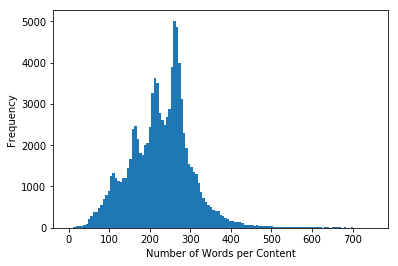

Median of the number of words per content = 231.0


In [27]:
%matplotlib inline
plt.hist(wordCntPerFV, bins=125, range=(0, 750))
plt.xlabel('Number of Words per Content')
plt.ylabel('Frequency')
plt.show()

print("Median of the number of words per content =", np.median(wordCntPerFV))

Based on the above histogram we can say that our hypothesis of setting the maxFVWordLength to the value we've chosen earlier holds good!

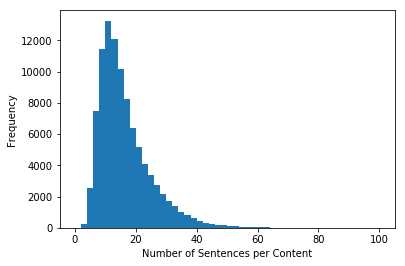

Median of the number of sentences per content = 14.0


In [28]:
%matplotlib inline
plt.hist(sentenceCntPerFV, bins=50, range=(0, 100))
plt.xlabel('Number of Sentences per Content')
plt.ylabel('Frequency')
plt.show()

print("Median of the number of sentences per content =", np.median(sentenceCntPerFV))

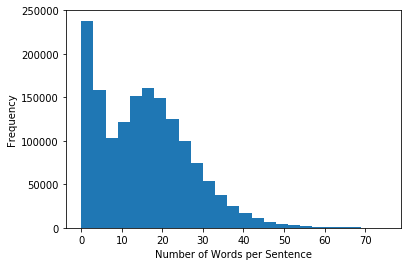

Median of the number of words per sentences = 15.0


In [29]:
%matplotlib inline
plt.hist(wordCntPerSentence, bins=25, range=(0, 75))
plt.xlabel('Number of Words per Sentence')
plt.ylabel('Frequency')
plt.show()

print("Median of the number of words per sentences =", np.median(wordCntPerSentence))

Based on the above histogram we can say that our hypothesis of setting the maxSentenceWordLength to the value we've chosen earlier holds good!

In [30]:
print("Total number of articles =", numWhiteListArticles)
print("Median of the number of sentences per content =", np.median(sentenceCntPerFV))
print("Median of the number of words per content =", np.median(wordCntPerFV))
print("Median of the number of words per sentences of articles =", np.median(wordCntPerSentence))

Total number of articles = 96934
Median of the number of sentences per content = 14.0
Median of the number of words per content = 231.0
Median of the number of words per sentences of articles = 15.0


#### Vectorize the data - Encode all the Labels & Content
Convert all articles into categorized labels and all the contents into vectors

In [31]:
print("Starting data encoding @", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

#--- Shuffle the dataset for one last time before encoding ---#
np.random.shuffle(whitelistedArticles)

articleIdx = 0
articleToID = {}
encodedLabels = np.zeros((numWhiteListArticles, len(categoryLabel)), dtype='int32')
encodedFV = np.zeros((numWhiteListArticles, maxFVWordLength), dtype='int32')

articleToIDChkPoint = "../data/medline_abstracts/checkpoints/articleToID.checkpoint-"
encodedLabelChkPoint = "../data/medline_abstracts/checkpoints/encodedLabel.checkpoint-"
encodedFVChkPoint = "../data/medline_abstracts/checkpoints/encodedFV.checkpoint-"

#--- Loop through all white-listed articles in the dataset and convert them into vector ---#
for articleRec in whitelistedArticles:
    
    #--- Convert the articles into IDs ---#
    articlePMID = articleRec['PMID']
    articleToID[articlePMID] = articleIdx
    
    #--- Encode the labels ---#
    encodedLabels[articleIdx] = fnGetLabels(articleIdx)
    
    #--- Encode the feature vectors ---#
    wordCounter = 0
    cleanedFV = fnCleanSentence(articleRec['FV'])
    split = fnComputeNGrams(cleanedFV, 1, True, True)
    
    for word in split:
        try:
            encodedFV[articleIdx][wordCounter] = wordsList.index(word)
        except:
            #--- Assign all unknown words to the maximum value possible ---#
            encodedFV[articleIdx][wordCounter] = maxVocab - 1
        #--- Increment the wordCounter ---#
        wordCounter = wordCounter + 1
        if wordCounter >= maxFVWordLength:
            break
        
    #--- Increment the articleIdx ---#
    articleIdx = articleIdx + 1
    
    #--- Checkpoint ---#
    if articleIdx % 10000 == 0:
        numChkPoint = int(articleIdx / 10000)
        print("\nCheckpoint", numChkPoint, "@", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "::", articleIdx, "articles processed")
        np.save(articleToIDChkPoint+str(numChkPoint), articleToID)
        np.save(encodedLabelChkPoint+str(numChkPoint), encodedLabels)
        np.save(encodedFVChkPoint+str(numChkPoint), encodedFV)

#--- Persist the final encoded dataset ---#
np.save('../data/medline_abstracts/articleToID', articleToID)
np.save('../data/medline_abstracts/encodedLabels', encodedLabels)
np.save('../data/medline_abstracts/encodedFV', encodedFV)

print("Completed data encoding @", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Starting data encoding @ 2018-05-17 11:00:09

Checkpoint 1 @ 2018-05-17 11:06:44 :: 10000 articles processed

Checkpoint 2 @ 2018-05-17 11:13:23 :: 20000 articles processed

Checkpoint 3 @ 2018-05-17 11:20:00 :: 30000 articles processed

Checkpoint 4 @ 2018-05-17 11:26:34 :: 40000 articles processed

Checkpoint 5 @ 2018-05-17 11:33:14 :: 50000 articles processed

Checkpoint 6 @ 2018-05-17 11:39:50 :: 60000 articles processed

Checkpoint 7 @ 2018-05-17 11:46:28 :: 70000 articles processed

Checkpoint 8 @ 2018-05-17 11:53:05 :: 80000 articles processed

Checkpoint 9 @ 2018-05-17 11:59:42 :: 90000 articles processed
Completed data encoding @ 2018-05-17 12:04:07


##### Remove the checkpoint files

In [32]:
os.system('rm -f ../data/medline_abstracts/checkpoints/*.checkpoint-*.npy')

0

Eye ball the encoding, as done above

In [33]:
print("articleToID for PMID = 29538200\n", articleToID['29538200'])
print("Disease Label for PMID = 29538200\n", encodedLabels[articleToID['29538200']])
print("Encoded Abstract for PMID = 29538200\n", encodedFV[articleToID['29538200']])

articleToID for PMID = 29538200
 41012
Disease Label for PMID = 29538200
 [1 0 0 0 0]
Encoded Abstract for PMID = 29538200
 [99999  7314  1010   516   429   603  4104  5125   925   195   327   414
 99999 50722   424  2467  1010    87   677 61403 16363  1680   709   566
  1065  1400 15560   505   331  6484   505  6756   314   505 10691   505
  3097  4279  9315    48   416 27016  1906   287 99999  7314   145  3062
   327   195 29136  2075  1026 14671  9604  4824   263   145  1656   429
   603  4104  5125   925   566 99999   111  4086   959  1812 14688  2140
 29141  1207  1123   404  3749 17698 99999  7172  4347   203 99999  7314
   740   333  1418  7114  1410   303 99999  1242    93   236 12393 17481
    48   522   145  3526   133  9262 24048 28179  2467  1010    87   532
 73066   429   566  1065 61403   759 99999  7314  4109   947  1553    89
   456   253   454    58    87   599   745    37   905  7466   641  7188
  3075  1038  1881    93   182   172  1063 12426    92 99999  7314   807


#### fnLoadData - Function to split the dataset and make it ready for LSTM
Develop a function which will take the dataset and split it and return a LSTM ready dataset

In [34]:
def fnLoadData(splitRatio):
    print("Starting the data wrangling @", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    numTestSet = int(numWhiteListArticles*splitRatio)
    numTrainingSet = numWhiteListArticles - numTestSet
    print("Size of Test Set =", numTestSet)
    print("Size of Training Set =", numTrainingSet)
    
    x_train = encodedFV[0:numTrainingSet, ]
    y_train = encodedLabels[0:numTrainingSet, ]
    
    x_test = encodedFV[numTrainingSet:numWhiteListArticles, ]
    y_test = encodedLabels[numTrainingSet:numWhiteListArticles, ]
    
    return (x_train, y_train), (x_test, y_test)

## Create Training and Validation Datasets

#### Split the dataset into training & test data
Split the entire dataset into training data and test data. As of now, we'll keep 80% of the data for training and 20% for testing

In [35]:
(x_train, y_train), (x_test, y_test) = fnLoadData(0.2)

Starting the data wrangling @ 2018-05-17 13:36:28
Size of Test Set = 19386
Size of Training Set = 77548


Check the dimensions of the training and test data sets

In [36]:
[x_train.shape, y_train.shape, x_test.shape, y_test.shape]

[(77548, 300), (77548, 5), (19386, 300), (19386, 5)]

## ANN Architecture: Fully Connected Deep Learning Neural Network

#### Load Dependencies
Load the packages that will be required

In [37]:
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Embedding
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam

/home/sxd24/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set the hyper parameters
Set the hyper-parameters which will be used in subsequent model generation

In [38]:
#--- Training ---#
epochs = 10
batch_size = 128

#--- Vector-Space Embedding ---#
n_dim = modelWord2Vec.vector_size
n_unique_words = maxVocab
# n_words_to_skip = 5
max_review_length = maxFVWordLength

#--- Dense Layer Architecture ---#
n_dense = 128
dropout_ratio = 0.35

#--- Print the hyper-parameters which are set from other variables ---#
print("n_dim =", n_dim)
print("n_unique_words =", n_unique_words)
print("max_review_length =", max_review_length)

n_dim = 200
n_unique_words = 100000
max_review_length = 300


#### Design the ANN architecture

In [39]:
modelFCDL = Sequential()
modelFCDL.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
# model.add(LSTM(units=200, activation='softsign'))
modelFCDL.add(Dense(n_dense, activation='relu', input_dim=n_dim))
modelFCDL.add(Dropout(dropout_ratio))
modelFCDL.add(Dense(n_dense, activation='relu'))
modelFCDL.add(Dropout(dropout_ratio))
modelFCDL.add(Dense(n_dense, activation='relu'))
modelFCDL.add(Dropout(dropout_ratio))
modelFCDL.add(Dense(n_dense, activation='relu'))
modelFCDL.add(Dropout(dropout_ratio))
modelFCDL.add(Dense(n_dense, activation='relu'))
modelFCDL.add(Dropout(dropout_ratio))
modelFCDL.add(Dense(n_dense, activation='relu'))
modelFCDL.add(Flatten())
modelFCDL.add(Dense(5, activation='sigmoid')) # mathematically equivalent to softmax with 5 classes

#--- Display the architecture of the generated model ---#
modelFCDL.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 200)          20000000  
_________________________________________________________________
dense_1 (Dense)              (None, 300, 128)          25728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 300, 128)          16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 300, 128)          16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 128)          0         
__________

#### Configure Model

In [40]:
modelFCDL.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# tensorboard = keras.callbacks.TensorBoard(log_dir="../logs", write_graph=True, write_images=True, histogram_freq=1)

#### Train the Model

In [41]:
print("Starting the model training @", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "...")
modelFCDL.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=False)
print("Completed the model training @", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Starting the model training @ 2018-05-17 13:37:01 ...
Train on 77548 samples, validate on 19386 samples
Epoch 1/10
77548/77548 [==============================] - 546s 7ms/step - loss: 1.1318 - acc: 0.5377 - val_loss: 0.8831 - val_acc: 0.6707
Epoch 2/10
77548/77548 [==============================] - 542s 7ms/step - loss: 0.7341 - acc: 0.7226 - val_loss: 0.7543 - val_acc: 0.7114
Epoch 3/10
77548/77548 [==============================] - 543s 7ms/step - loss: 0.6329 - acc: 0.7521 - val_loss: 0.7426 - val_acc: 0.7162
Epoch 4/10
77548/77548 [==============================] - 540s 7ms/step - loss: 0.5728 - acc: 0.7664 - val_loss: 0.7417 - val_acc: 0.7238
Epoch 5/10
77548/77548 [==============================] - 541s 7ms/step - loss: 0.5141 - acc: 0.7829 - val_loss: 0.7010 - val_acc: 0.7379
Epoch 6/10
77548/77548 [==============================] - 543s 7ms/step - loss: 0.4747 - acc: 0.7931 - val_loss: 0.6900 - val_acc: 0.7461
Epoch 7/10
77548/77548 [==============================] - 543s 7ms/s

# Extra Code - Do not execute, but for reuse

## ANN Architecture - Multi-ConvNet Deep Learning Neural Network

In [ ]:
import keras
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, Input, concatenate, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam

#### Set the hyper parameters
Set the hyper-parameters which will be used in subsequent model generation

In [ ]:
#--- Training ---#
epochs = 6
batch_size = 128

#--- Vector-Space Embedding ---#
n_dim = modelWord2Vec.vector_size
n_unique_words = maxVocab
# n_words_to_skip = 5
max_review_length = maxFVWordLength
dropout_ratio_embed = 0.2

#--- Convolutional Layer Architecture:
n_conv_1 = n_conv_2 = n_conv_3 = 128 
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

#--- Dense Layer Architecture ---#
n_dense = 128
dropout_ratio = 0.4

#--- Print the hyper-parameters which are set from other variables ---#
print("n_dim =", n_dim)
print("n_unique_words =", n_unique_words)
print("max_review_length =", max_review_length)

#### Design the ConvNet Architecture
ANN architecture with ConvNets

In [ ]:
input_layer = Input(shape=(max_review_length,), dtype='int16', name='input') # supports integers +/- 32.7k 
embedding_layer = Embedding(n_unique_words, n_dim, input_length=max_review_length, name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(dropout_ratio_embed, name='drop_embed')(embedding_layer)

conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout_ratio, name='drop_dense_01')(dense_layer)
dense_2 = Dense(128, activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(dropout_ratio, name='drop_dense_2')(dense_2)

predictions = Dense(5, activation='sigmoid', name='output')(dropout_2)

modelCNN = Model(input_layer, predictions)

#--- Display the architecture of the generated model ---#
modelCNN.summary()

#### Configure Model

In [ ]:
modelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# tensorboard = keras.callbacks.TensorBoard(log_dir="../logs", write_graph=True, write_images=True, histogram_freq=1)

#### Train the Model

In [ ]:
print("Starting the model training @", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "...")
modelCNN.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=False)
print("Completed the model training @", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
import psutil
psutil.virtual_memory()

In [ ]:
#--- Create model checkpoint ---#
modelOutputDir = '../model-output/ann'
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Check the function fnGetLabels() with some test data

In [ ]:
print("Encoded label for article with index = 0:\n", fnGetLabels(32000))

##### Load the data if datasets are empty
Load data from the *.npy if the datasets are empty

In [ ]:
if len(quarantineArticles) == 0:
    print("quarantineArticles is empty! Reloading the data from quarantineArticles.npy ...")
    QuarantineArticles = np.load('../data/medline_abstracts/npQuarantineArticles.npy')
else:
    print("quarantineArticles already contain data!")

if len(whitelistedArticles) == 0:
    print("whitelistedArticles is empty! Reloading the data from whitelistedArticles.npy ...")
    whitelistedArticles = np.load('../data/medline_abstracts/npWhiteListArticles.npy')
else:
    print("whitelistedArticles already contain data!")

In [ ]:
print(whitelistedArticles)